In [1]:
%matplotlib inline

import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D

from tensorflow import keras

In [2]:
data_path = 'C:/Users/User/Desktop/random_split/random_split/'
print('Available data', os.listdir(data_path))

Available data ['dev', 'test', 'train']


In [3]:
def read_data(partition):
    data = []
    for fn in os.listdir(os.path.join(data_path, partition)):
        with open(os.path.join(data_path, partition, fn)) as f:
            data.append(pd.read_csv(f, index_col=None))
    return pd.concat(data)

In [4]:
df_train = read_data('train')
df_val = read_data('dev')
df_test = read_data('test')

In [5]:
df_train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


In [6]:
classes = df_train['family_accession'].value_counts()[:1000].index.tolist()
len(classes)

1000

In [7]:
train_sm = df_train.loc[df_train['family_accession'].isin(classes)].reset_index()
val_sm = df_val.loc[df_val['family_accession'].isin(classes)].reset_index()
test_sm = df_test.loc[df_test['family_accession'].isin(classes)].reset_index()
#if ram full try to decrease this numbers below
train_sm = train_sm[:50000]
val_sm = val_sm[:10000]
test_sm = test_sm[:10000]

In [8]:
print('Data size after considering 1000 classes for each data split:')
print('Train size :', len(train_sm))
print('Val size :', len(val_sm))
print('Test size :', len(test_sm))

Data size after considering 1000 classes for each data split:
Train size : 50000
Val size : 10000
Test size : 10000


## Text Processing

In [9]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
    char_dict = {}
    for index, val in enumerate(codes):
        char_dict[val] = index+1

    return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [10]:
def integer_encoding(data):
    encode_list = []
    for row in data['sequence'].values:
        row_encode = []
        for code in row:
            row_encode.append(char_dict.get(code, 0))
        encode_list.append(np.array(row_encode))
  
    return encode_list

In [11]:
train_encode = integer_encoding(train_sm) 
val_encode = integer_encoding(val_sm) 
test_encode = integer_encoding(test_sm)

In [12]:
max_length = 100
train_pad = pad_sequences(train_encode, maxlen=max_length, padding='post', truncating='post')
val_pad = pad_sequences(val_encode, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_encode, maxlen=max_length, padding='post', truncating='post')

train_pad.shape, val_pad.shape, test_pad.shape

((50000, 100), (10000, 100), (10000, 100))

In [13]:
train_ohe = to_categorical(train_pad)
val_ohe = to_categorical(val_pad)
test_ohe = to_categorical(test_pad)
train_ohe.shape, val_ohe.shape, test_ohe.shape

((50000, 100, 21), (10000, 100, 21), (10000, 100, 21))

In [14]:
le = LabelEncoder()
y_train_le = le.fit_transform(train_sm['family_accession'])
y_val_le = le.transform(val_sm['family_accession'])
y_test_le = le.transform(test_sm['family_accession'])
y_train_le.shape, y_val_le.shape, y_test_le.shape

((50000,), (10000,), (10000,))

In [15]:
y_train = to_categorical(y_train_le)
y_val = to_categorical(y_val_le)
y_test = to_categorical(y_test_le)
y_train.shape, y_val.shape, y_test.shape

((50000, 1000), (10000, 1000), (10000, 1000))

In [16]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

In [17]:
# Utility function: Display model score(Loss & Accuracy) across all sets.
def display_model_score(model, train, val, test, batch_size):
  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

In [18]:
encoder = Input(shape=(100,21))
#emb = Embedding(21, 128, input_length=max_length)(encoder)
bi_rnn = Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)
                            , bias_regularizer=l2(0.01)))(encoder)
encoded = Dropout(0.3)(bi_rnn)
# softmax classifier
decoder = Dense(1000, activation='softmax')(encoded)
biRNN = Model(inputs=encoder, outputs=decoder)
biRNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
biRNN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 21)]         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               44032     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1000)              129000    
Total params: 173,032
Trainable params: 173,032
Non-trainable params: 0
_________________________________________________________________


In [31]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
biLSTM = biRNN.fit(
    train_ohe, y_train,
    epochs=200, batch_size=64,
    validation_data=(val_ohe, y_val),
    callbacks=[es])

Epoch 1/200
782/782 [==============================] - 64s 79ms/step - loss: 3.1873 - accuracy: 0.4475 - val_loss: 2.9529 - val_accuracy: 0.5122
Epoch 2/200
782/782 [==============================] - 63s 81ms/step - loss: 2.9972 - accuracy: 0.4875 - val_loss: 2.6778 - val_accuracy: 0.5945
Epoch 3/200
782/782 [==============================] - 61s 78ms/step - loss: 2.8452 - accuracy: 0.5223 - val_loss: 2.5468 - val_accuracy: 0.6111
Epoch 4/200
782/782 [==============================] - 57s 73ms/step - loss: 2.7506 - accuracy: 0.5427 - val_loss: 2.5325 - val_accuracy: 0.6117
Epoch 5/200
782/782 [==============================] - 79s 101ms/step - loss: 2.6734 - accuracy: 0.5622 - val_loss: 2.4365 - val_accuracy: 0.6360
Epoch 6/200
782/782 [==============================] - 71s 91ms/step - loss: 2.6026 - accuracy: 0.5762 - val_loss: 2.3147 - val_accuracy: 0.6614
Epoch 7/200
782/782 [==============================] - 78s 100ms/step - loss: 2.5001 - accuracy: 0.5985 - val_loss: 2.2159 - val_

In [32]:
biRNN.save('biRNN.h5')

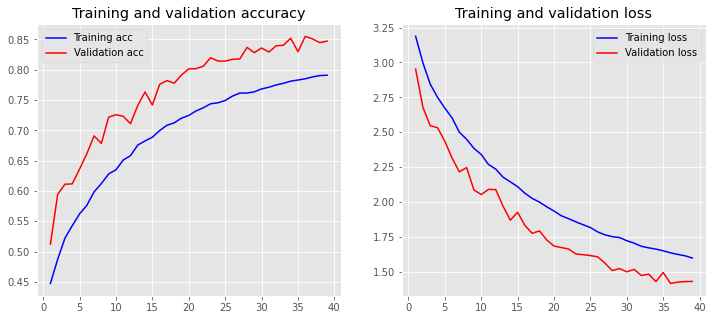

In [33]:
plot_history(biLSTM)

In [34]:
model = keras.models.load_model('biRNN.h5')

In [35]:
prediction=np.rint(model.predict(test_ohe[:1:]))

In [36]:
prediction

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [37]:
y_test[:1:]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [38]:
np.linalg.norm(prediction -y_test[:1:])

0.0

In [39]:
def prepare(sequence):
    encode_list = []
    for seq in sequence:
        row_encode = []
        for code in seq:
            row_encode.append(char_dict.get(code, 0))
        encode_list.append(np.array(row_encode))
    max_length = 100
    seq_pad = pad_sequences(encode_list, maxlen=max_length, padding='post', truncating='post')
    seq_ohe = to_categorical(seq_pad)
    return seq_ohe

In [40]:
sequence=["PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRA","RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG"]
seq_ohe=prepare(sequence)
seq_ohe.shape

(2, 100, 21)

In [41]:
prediction=np.rint(model.predict(seq_ohe))

In [42]:
x = PrettyTable()
x.field_names = ['Sr.no', 'Model', 'Train Acc', 'Val Acc','Test Acc']
x.add_row(['1.', 'Bidirectional LSTM', '0.964', '0.957', '0.958'])
print(x)

+-------+--------------------+-----------+---------+----------+
| Sr.no |       Model        | Train Acc | Val Acc | Test Acc |
+-------+--------------------+-----------+---------+----------+
|   1.  | Bidirectional LSTM |   0.964   |  0.957  |  0.958   |
+-------+--------------------+-----------+---------+----------+
